In [1]:
import numpy as np

In [15]:
class Atom:
    def __init__(self,x,y,z,element,charge,notused,fx,fy,fz,hydrogens,oxygen):
        self.x=float(x)
        self.y=float(y)
        self.z=float(z)
        self.element=str(element)
        self.charge=float(charge)
        self.notused=int(float(notused))
        self.fx=float(fx)
        self.fy=float(fy)
        self.fz=float(fz)
        self.hydrogens=hydrogens
        self.oxygen=oxygen
    
    @classmethod
    def from_lammps(cls, element, x, y, z,notused):
        obj = object.__new__(cls)
        obj.x = float(x)
        obj.y = float(y)
        obj.z = float(z)
        obj.element = str(element)
        obj.notused = notused
        obj.hydrogens=[]
        obj.oxygen=None
        return obj
    
    def scan_vicinity(self,config,cutoff,boxl):
        pivot=np.array([self.x,self.y,self.z])
        config=np.array(config)
        for ind,i in enumerate(config):
            #print(str(ind)+" element= "+i.element,type(i.notused))
            if(i.element=="O"):
                i_vector=np.array([i.x,i.y,i.z])
                #print("O at"+str(ind))
                direction=pivot-i_vector
                direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
                direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
                direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
                dist=np.linalg.norm(direction)
                if(dist<cutoff):
                    #can set notused = 1 here. Need to ponder
                    
                    return False
        return True
    
    def calc_dist(self,pivot,i_vector,boxl):
        direction=pivot-i_vector
        direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
        direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
        direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
        dist=np.linalg.norm(direction)
        return dist
    
    def scan_H_OH(self,config,cutoff,boxl):
        pivot=np.array([self.x,self.y,self.z])
        config=np.array(config)
        for ind,i in enumerate(config):
            if(i.element=="H"):
                i_vector=np.array([i.x,i.y,i.z])
                dist=self.calc_dist(pivot,i_vector,boxl)
                if(dist<cutoff):
                    if(len(self.hydrogens)<2):
                        self.hydrogens.append((i,dist))
                        #print("before sorting: ",i.hydrogens)
                        self.hydrogens.sort(key=lambda tup: tup[1])
                        #print("after sorting: ",i.hydrogens)
                        i.oxygen=self
                    elif(dist<self.hydrogen[-1]):
                        self.hydrogen[-1][0].oxygen=None
                        self.hydrogen.pop()
                        self.hydrogen.append((i,dist))
                        #print("before sorting: ",i.hydrogens)
                        self.hydrogens.sort(key=lambda tup: tup[1])
                        #print("after sorting: ",i.hydrogens)
                        i.oxygen=self
                    else:
                        print("RAN INTO ERROR:",i,i.hydrogens)
                        
                        
        
                

In [16]:
def parse(f_name):
    config=[]
    with open(f_name,'r') as f:
        temp=[]
        for i in f.readlines():
            i=str(i)
            #print(i)
            if("begin" in i):
                temp=[]
            elif("end" in i):
                config.append(temp)
                break # need to remove for a whole file
            elif(i.startswith("atom")):
                a=i.split()
                temp.append(Atom(a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9]))
    #for j in config:
    #    for i in j:
    #        print(i.element,type(i.element))
    return config                  

In [17]:
def parse_lammps_output(f_name):
    atoms=['O','H']
    config=[]
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("ITEM: TIMESTEP" in i):
                if(ind>0):
                    config.append(temp)
                temp=[]
            elif(any(i.startswith(a) for a in atoms)):
                a=i.split()
                #print(a)
                temp.append(Atom.from_lammps(a[0],a[1],a[2],a[3],0))
    return config


In [18]:
def pH(proton_count,boxl,Na):
    print("Proton Count = "+str(proton_count))
    n=proton_count/Na
    vol=1000*(boxl**3)
    #Molarity=n/vol
    #print("molarity=",Molarity)
    return -1*(np.log10(n)-np.log10(vol))

In [26]:
from sys import argv as a
import numpy as np
import matplotlib.pyplot as plt
import json

def main():
    cutoff=1.15 # 2.173185 # needs to be atomic units since the coordinates are in atomic units
    boxl_atomic=46.937#23.465110
    Na=6.0221409e+23
    atomic_to_angstron=0.5291772083
    boxl_angstron=boxl_atomic*atomic_to_angstron
    boxl_meters=boxl_angstron**-8
    
    
    #config=parse("../training-set/input.data")
    config=parse_lammps_output("./out6.lammpstrj")
    #print(config[0])
    
    
    config=config[:100]
    print("config size",np.shape(config))
    protons=[]
    
    
    for ind,j in enumerate(config):
        #print("number of atoms = ",len(j))
        proton_count=0
        oh_count=0
        h2o_count=0
        for ind2,i in enumerate(j):
            if(i.element=="O"):
                #print("H at"+str(ind2))
                i.scan_H_OH(j,cutoff,boxl_atomic)
        for ind2,i in enumerate(j):
            if(i.element=="H"): 
                if(i.oxygen==None):
                    proton_count+=1
            elif(i.element=="O" and len(i.hydrogens)==1):
                oh_count+=1
            elif(i.element=="O" and len(i.hydrogens)==2):
                h2o_count+=1
            else:
                print("something happened here",i,json.dumps(i.__dict__))
                
        total=proton_count+2*oh_count+3*h2o_count
        protons.append((proton_count,oh_count,h2o_count,total))
        print(protons[-1])
        
    ph=[]
    for i,prot in enumerate(protons):
        ph_temp=pH(prot[0],boxl_atomic*(10**-10),Na)
        poh_temp=pH(prot[1],boxl_atomic*(10**-10),Na)
        #print(i,". pH = ",ph_temp)
        ph.append((ph_temp,poh_temp))
    return protons,ph
    
    
    
    #    print("pH of config-"+str(ind)+" = "+str(pH(proton_count,boxl_meters,Na)))

In [27]:
if __name__ == "__main__":
    protons,ph=main()
    protons=np.array(protons)
    ph=np.array(ph)
    #print("protons by config= ",protons)
    
 

config size (100, 192)
(7, 7, 57, 192)
(7, 7, 57, 192)
(7, 7, 57, 192)
(7, 7, 57, 192)
(7, 7, 57, 192)
(7, 7, 57, 192)
(7, 7, 57, 192)
(7, 7, 57, 192)
(8, 8, 56, 192)
something happened here <__main__.Atom object at 0x7fd0ea0b92e8> {"x": 13.0532, "y": 44.0176, "z": 8.91713, "element": "O", "notused": 0, "hydrogens": [], "oxygen": null}
something happened here <__main__.Atom object at 0x7fd0ea0b9c50> {"x": 18.917, "y": 43.4622, "z": 44.5511, "element": "O", "notused": 0, "hydrogens": [], "oxygen": null}
(19, 15, 47, 190)
something happened here <__main__.Atom object at 0x7fd0e95c6d30> {"x": 12.8105, "y": 44.0018, "z": 8.89835, "element": "O", "notused": 0, "hydrogens": [], "oxygen": null}
something happened here <__main__.Atom object at 0x7fd0e95cd710> {"x": 19.1356, "y": 43.4127, "z": 44.3203, "element": "O", "notused": 0, "hydrogens": [], "oxygen": null}
(19, 15, 47, 190)
something happened here <__main__.Atom object at 0x7fd0e95d87f0> {"x": 12.5458, "y": 44.0111, "z": 8.85277, "eleme

(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
(8, 8, 56, 192)
something happened here <__main__.Atom object at 0x7fd0e8c7e5c0> {"x": 20.1036, "y": 4.90829, "z": 44.9499, "element": "O", "notused": 0, "hydrogens": [], "oxygen": null}
(7, 5, 58, 191)
something happened here <__main__.Atom object at 0x7fd0e8c91080> {"x": 20.0648, "y": 4.98298, "z": 44.8579, "element": "O", "notused": 0, "hydrogens": [], "oxygen": null}
(7, 5, 58, 191)
something happened here <__main__.Atom object at 0x7fd0e8c9db00> {"x": 20.046, "y": 5.09537, "z": 44.6849, "element": "O", "notused": 0, "hydrogens": [], "oxygen": null}
(7, 5, 58, 191)
something happened here <__main__.Atom object at 0x7fd0e8cb15c0> {"x": 20.0201, "y": 5.20078, "z": 44.4721, "element": "O", "notused": 0, "hydrogens": [], "oxygen": null}
(7, 5, 58, 191)
something happened here <__main__.Atom object at 0x7fd0e8c43080> {"x": 19.953

In [21]:
count_91=0
count_90=0
count_shorts=0
for i in protons:
    if(i[3]==191 and i[0]-i[1]==2):
        count_91+=1
    elif(i[3]==190 and i[0]-i[1]==4):
        count_90+=1
    elif(i[3]!=192):
        count_shorts+=1
        
print(count_91,count_90,count_shorts)

38 19 0


In [9]:
print("pH,pOH by config= ",ph)

pH,pOH by config=  [[0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.89120691 0.89120691]
 [0.5155433  0.61820564]
 [0.5155433  0.61820564]
 [0.5155433  0.61820564]
 [0.5155433  0.61820564]
 [0.5155433  0.61820564]
 [0.5155433  0.61820564]
 [0.5155433  0.61820564]
 [0.7942969  1.01614565]
 [0.7942969  1.01614565]
 [0.7942969  1.01614565]
 [0.7942969  1.01614565]
 [0.7942969  1.01614565]
 [0.7942969  1.01614565]
 [0.84005439 0.94919886]
 [0.84005439 0.94919886]
 [0.84005439 0.94919886]
 [0.84005439 0.94919886]
 [0.89120691 1.01614565]
 [0.84005439 1.09532689]
 [0.84005439 1.09532689]
 [0.84005439 1.09532689]
 [0.84005439 1.09532689]
 [0.84005439 1.09532689]
 [0.84005439 1.09532689]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94919886 0.94919886]
 [0.94

In [10]:
print("pKw by config= ")
for i in ph:
    print(i[0]+i[1])

pKw by config= 
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.7824138190841268
1.133748933059504
1.133748933059504
1.133748933059504
1.133748933059504
1.133748933059504
1.133748933059504
1.133748933059504
1.8104425426843704
1.8104425426843704
1.8104425426843704
1.8104425426843704
1.8104425426843704
1.8104425426843704
1.7892532436144322
1.7892532436144322
1.7892532436144322
1.7892532436144322
1.9073525556924267
1.9353812792926703
1.9353812792926703
1.9353812792926703
1.9353812792926703
1.9353812792926703
1.9353812792926703
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.8983977130395004
1.6801087741893639
1.6801087741893639
1.6801087741893639
1.6801087741893639
1.6801087741893639
1.7824138190841268
1.7824138190841268
1.7824138190841268
1.7824138190841268
1.7824138190841268
1.7824138190841268
1.7824138190841268
1.7

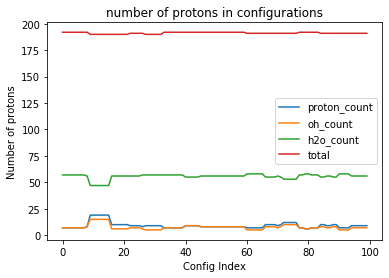

In [11]:
plt.title("number of protons in configurations")
plt.xlabel('Config Index')
plt.ylabel('Number of protons')
plt.plot(np.arange(len(protons)),protons)
plt.legend(['proton_count','oh_count','h2o_count','total'])
plt.show()

([array([ 0.,  2., 30., 17., 24., 15.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,
          0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,

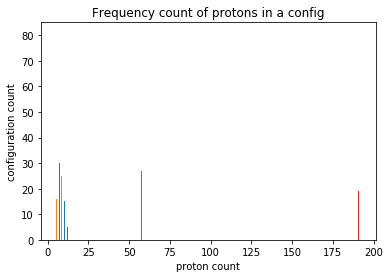

In [12]:
plt.title("Frequency count of protons in a config")
plt.xlabel("proton count")
plt.ylabel("configuration count")
plt.hist(protons, bins=np.arange(protons.min(), protons.max()+1))


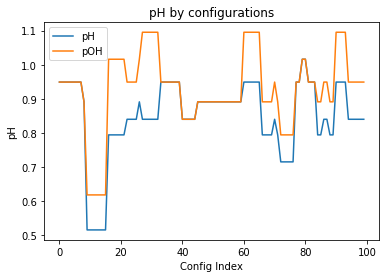

In [13]:
plt.title("pH by configurations")
plt.xlabel('Config Index')
plt.ylabel('pH')
plt.plot(np.arange(len(ph)),ph)
plt.legend(['pH','pOH'])
plt.show()

In [14]:
disassociation const 

SyntaxError: invalid syntax (<ipython-input-14-f407b956dc94>, line 1)